# Эксперименты с `module2graph`
## Подготовка
### Импорт библиотек

In [ ]:
import torch
from torch import nn
from torch.fx import symbolic_trace

from typing import Callable
from functools import reduce, partial
import re

import matplotlib.pylab as plt
%matplotlib inline
import networkx

### Реализация модулей

In [7]:
class Gamma(torch.nn.Module):
    def __init__(self, initial_gamma = 0.0) -> None:
        super().__init__()
        self.param = torch.nn.Parameter(torch.tensor(initial_gamma))
        self.discrete = False 
    
    def make_discrete(self):
        raise NotImplementedError()
    

    def forward(self):
        return self.param  
    
class SigmoidGamma(Gamma):
    def make_discrete(self):
        self.discrete = True 
        self.param.requires_grad = False 

    def forward(self):
        if self.discrete:
            return 1.0 * (self.param)
        else:
            return torch.sigmoid(self.param)

        
def get_module_by_name(module,
                       access_string: str):
    """Retrieve a module nested in another by its access string.

    Works even when there is a Sequential in the module.
    """
    names = access_string.split(sep='.')
    return reduce(getattr, names, module)
  
def gamma_hook(module, inp, out, gamma,  intermediate_dict, proper2real_label, real2proper_label, label, proper_label):
    result = out * gamma()
    intermediate_dict[proper_label] = result 
    proper2real_label[proper_label] = label 
    real2proper_label[label] = proper_label

    return result 

def make_gamma_hooks(module: torch.nn.Module, graph_module, gamma_constructor: Callable):
    node2node = {}
    for node in graph_module.graph.nodes:
      for node2 in node.all_input_nodes:
        if node2 not in node2node:
          node2node[node2] = []
        node2node[node2].append(node)


    modified = True
    while modified:
      modified = False 
      for node in node2node:
        to_del = set()
        for i in range(len(node2node[node])):
          if node2node[node][i].op != 'call_module':
            modified = True
            to_del.add(node2node[node][i])
            if node2node[node][i] in node2node: # check that not output
              node2node[node].extend(node2node[node2node[node][i]])
          for node2 in to_del:
            node2node[node].remove(node2)
            
    to_del = set()
    to_change = set()

    for node in node2node:
      if node.op != 'call_module':
        to_del.add(node)
      else:
        to_change.add(node)
    for node in to_del:
      del node2node[node]  
    for node in to_change:
      new_result = [str(node2.target).replace('.', '_') for node2 in node2node[node]]
      node2node[str(node.target).replace('.', '_')] = new_result
      del node2node[node]
    for node in graph_module.graph.nodes:
        if node.op == "call_module":
            tgt = node.target.replace('.', '_')
            if (tgt not in node2node) or (len(node2node[tgt]) == 0):
          
                print (str(node), 'output')
                node2node[str(node)] = ['output']
    module.node2node = node2node
    
    nodes = set()

    
    for node in graph_module.graph.nodes:
        #print (node.target, node.op)
        if node.op == "call_module":
            nodes.add(node.target)
    
    module.gammas = []
    module.intermediate = {}
    module.proper2real_label = {}
    module.real2proper_label = {}

    for node in nodes:
        submodule = get_module_by_name(module, node)
        new_gamma = gamma_constructor()
        node_intermediate_name = str(node)
        node_propper_name = str(node_intermediate_name.replace('.', '_'))
        
        submodule.add_module(f'gamma_{node_propper_name}', new_gamma)
        submodule.register_forward_hook(partial(gamma_hook, gamma = new_gamma, intermediate_dict = module.intermediate,
                                                label = node_intermediate_name, 
                                                proper2real_label = module.proper2real_label,
                                                  real2proper_label = module.real2proper_label,
                                                    proper_label = node_propper_name))
        for param in new_gamma.parameters():
            module.gammas.append(param)
def make_graph_description(graph_module, operations = None):
    nonwords = re.compile('[^A-Za-z0-9\s]+')
    if operations is None:
        operations = ['call_module']

    e = {}
    for node in graph_module.graph.nodes:
        if node.op in operations:
            #почему-то аргументы идут с нижним подчеркивание вместо точки
            in_ = nonwords.sub('.', node.name)
            e[(in_,  node.op)] = []
            for out_ in list(node.args) + list(node.kwargs):
                #print (str(out_), nonwords.sub(' ', str(out_)))
                try:
                    out_ = nonwords.sub('.', out_.name)
                except:
                    out_ = nonwords.sub('.', str(out_))
               
                e[(in_,  node.op)].append((out_))
    return e 

def networkx_plot_graph(graph_module, operations=None):
    try:
        import networkx as nx 
    except:
        print ('install networkx')
        return 
    if operations is None:
        operations = ['call_module']

    e = make_graph_description(graph_module, operations=operations)
    color_map = ['b', 'g', 'r']
    
    graph = nx.DiGraph()
    vert_colors = {}
    for in_ in e:
        in_, op = in_ 
        vert_colors[in_] = color_map[operations.index(op)]
        
        for out_ in e[(in_, op)]:
            graph.add_edge(out_, in_)
    vert_color_list = []
    for node in graph.nodes:
        vert_color_list.append(vert_colors.get(node, 'gray'))

    return graph, vert_color_list 

### Простая FCN

In [8]:
model = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
)

traced_graph = symbolic_trace(model)
make_graph_description(traced_graph)

{('.0', 'call_module'): ['input.1'],
 ('.1', 'call_module'): ['.0'],
 ('.2', 'call_module'): ['.1']}

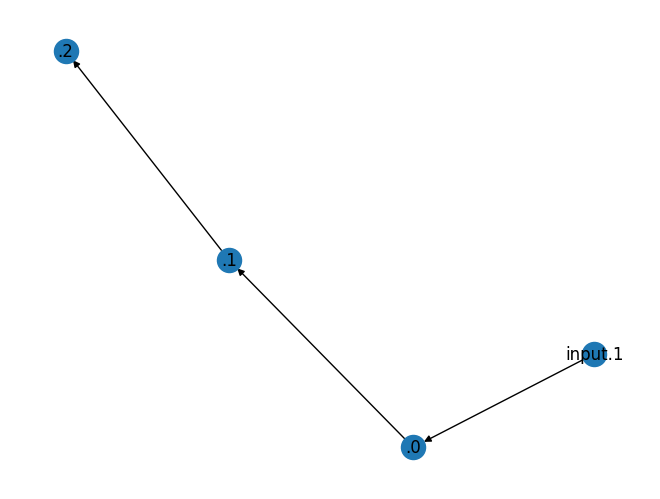

In [ ]:
networkx.draw(networkx_plot_graph(traced_graph)[0], with_labels=True)

### Resnet

In [22]:
from torchvision import models
model = models.resnet50(weights='DEFAULT')
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

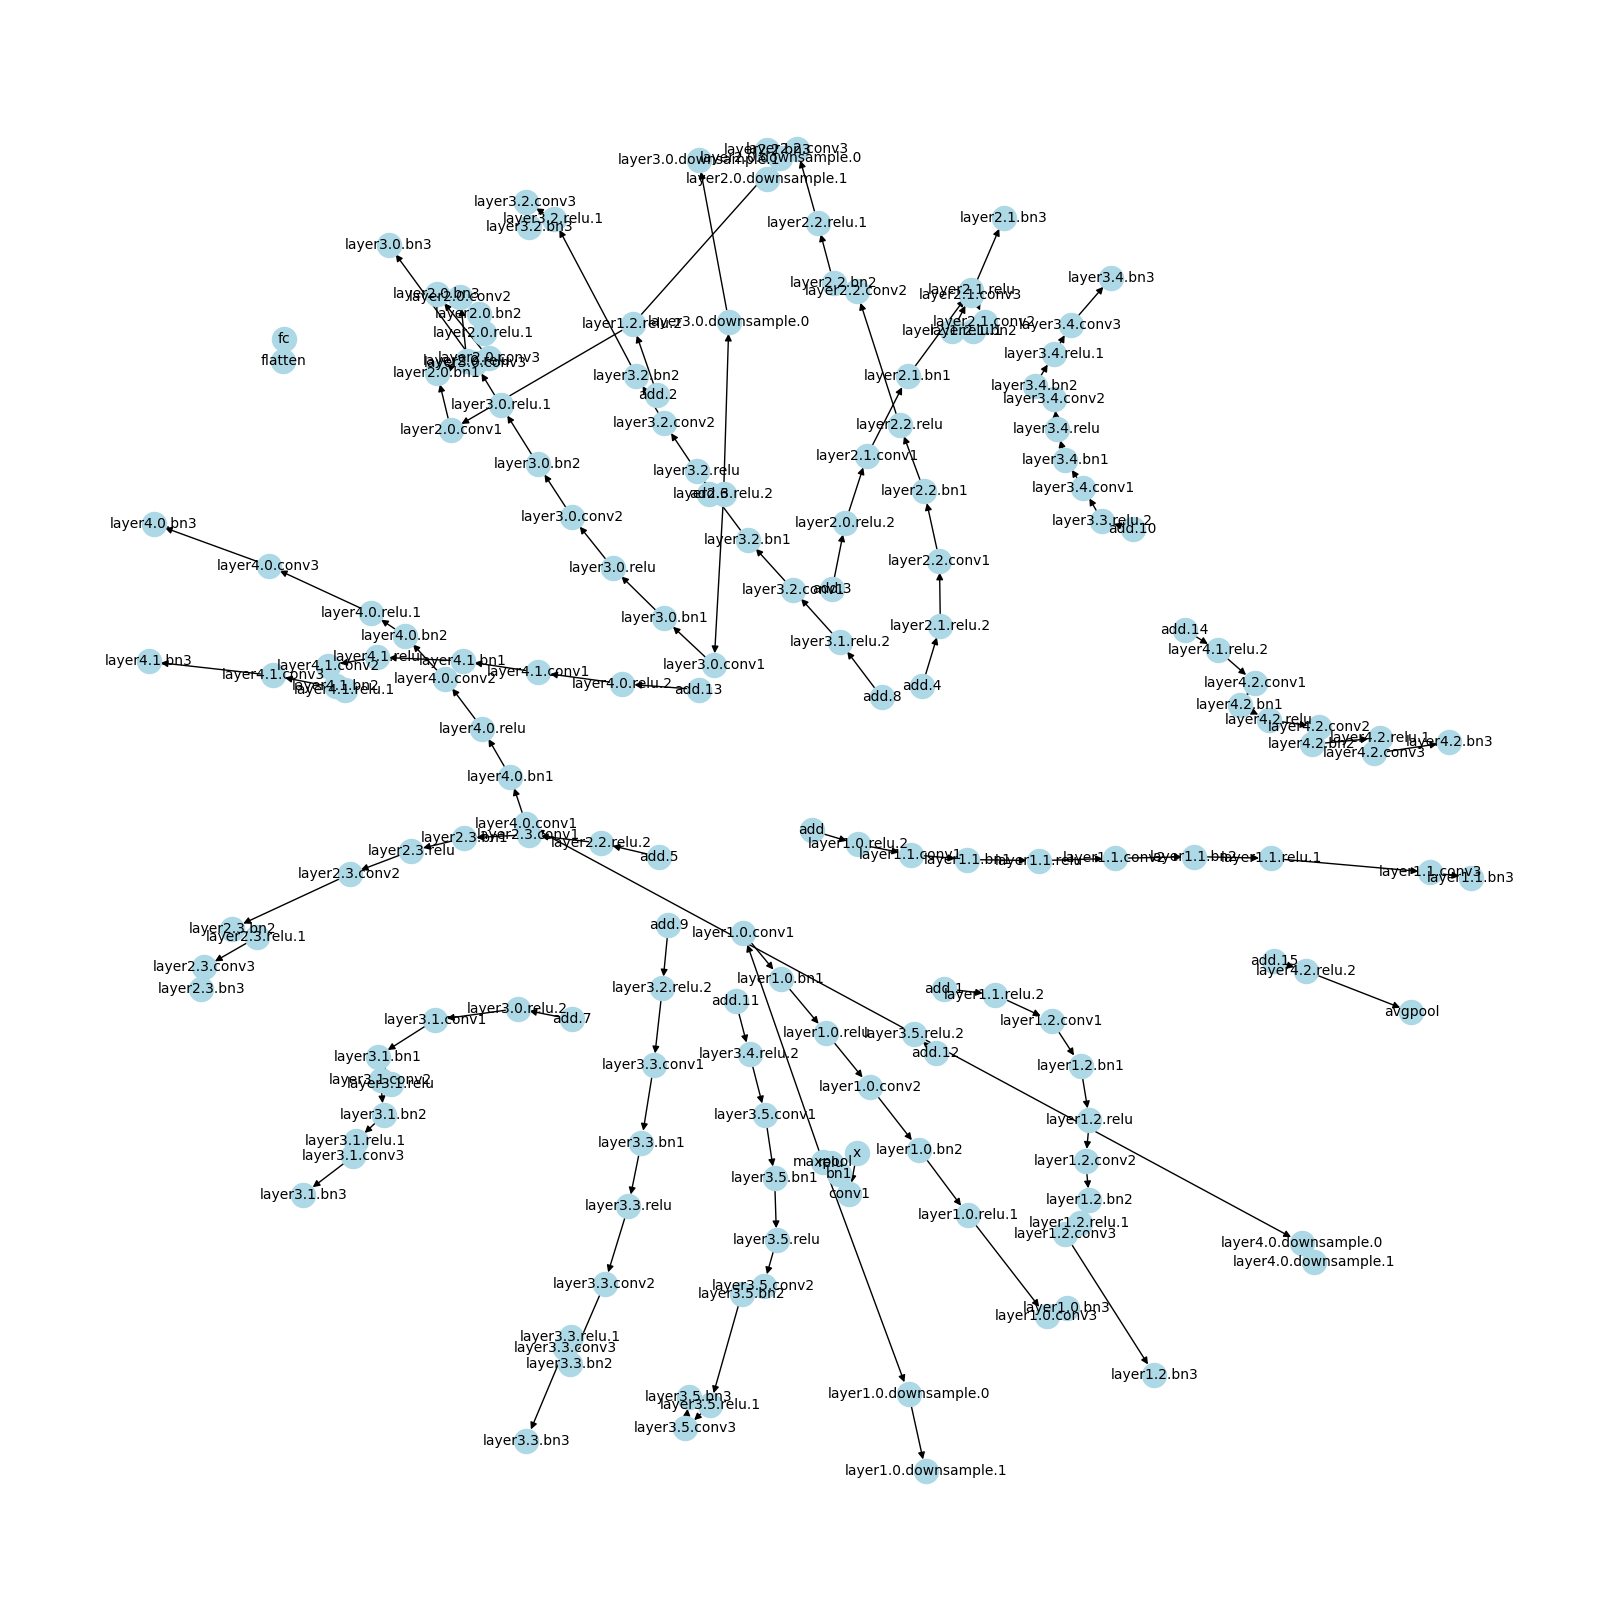

In [23]:
traced_graph = symbolic_trace(model)
plt.figure(figsize=(16, 16))
networkx.draw(networkx_plot_graph(traced_graph)[0], with_labels=True, node_color='lightblue', font_size=10)

In [24]:
!pip install torchview -q

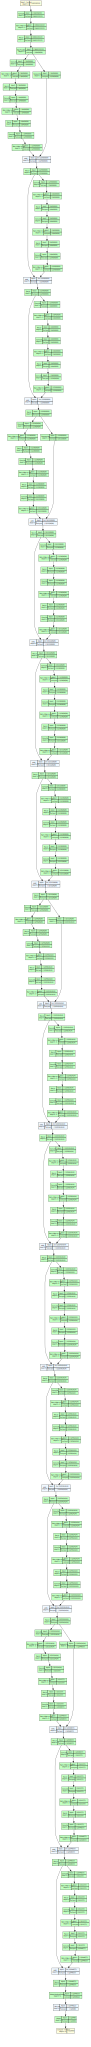

In [25]:
from torchview import draw_graph
g = draw_graph(model, input_size=(1,3,224,224), hide_inner_tensors=True)
g.visual_graph